### Trabajo Práctico Final - ERV 
## Detección de fallas en neumáticos
**Alumno:** Manuel García Tornadú

La idea del trabajo es replicar los procedimientos para la detección de fallas en neumáticos usados en el paper **"Tire appearance defect detection method via combining HOG and LBP features"** escrito por Hongbin Liu, Xinghao Jia, Chenhui Su, Hongjuan Yang and Chengdong Li.


In [334]:
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import random
from IPython.display import display

## Procesamiento de imágenes

In [134]:
#carpetas de ubicación del dataset
carpeta_entrenamiento_normal = Path('./training_data/normal')
carpeta_entrenamiento_cracked = Path('./training_data/cracked')
carpeta_test_normal = Path('./testing_data/normal')
carpeta_test_cracked = Path('./testing_data/cracked')

#### Algunas muestras del dataset:

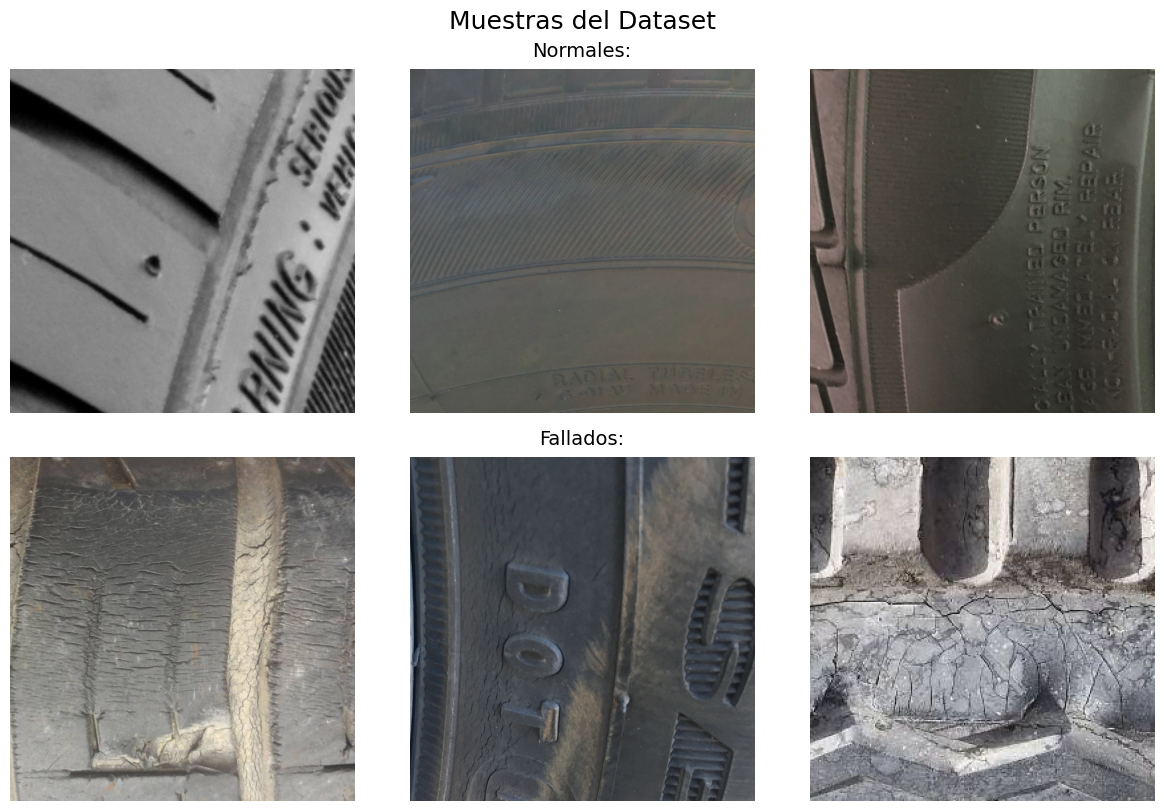

In [161]:
lista_normales = list(carpeta_entrenamiento_normal.glob(r"*.jpg"))
lista_falladas = list(carpeta_test_cracked.glob(r"*.jpg"))

fig = plt.figure(constrained_layout=True, figsize=(12, 8))
fig.suptitle('Muestras del Dataset', size=18)

subfigs = fig.subfigures(nrows=2, ncols=1)

subfigs[0].suptitle('Normales:', size=14)
subfigs[1].suptitle('Fallados:', size=14)

axs = subfigs[0].subplots(nrows=1, ncols=3)
for ax in axs.flat:
    imagen = np.array(Image.open(random.choice(lista_normales)))
    ax.axis('off')
    ax.imshow(imagen)

axs = subfigs[1].subplots(nrows=1, ncols=3)
for ax in axs.flat:
    imagen = np.array(Image.open(random.choice(lista_falladas)))
    ax.axis('off')
    ax.imshow(imagen)


#### Funciones para el procesamiento de imágenes:

In [71]:
#Cambia la imagen a escala de grises con los parámteros que se usan en el paper
def pasa_a_escala_de_gris(imagen):
    img = np.array(imagen)
    return np.int8(img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.144)


# Modifica el tamaño de la imagen usando el método de interpolación bilinear usado en el paper
def cambia_dimension(imagen, dimension):
    imagen_escalada = imagen.resize((dimension, dimension), Image.BILINEAR)
    return imagen_escalada


# Procesa toda una carpeta de imagenes: las pasa a escala de gris y luego reduce el tamaño al pasado por parámetro.
# Guarda las imagenes en una carpeta y devuelve la ruta de la misma
def procesa_imagenes(carpeta, dim):
    lista_nombres = list(carpeta.glob(r"*.jpg"))
    nombre_carpeta = "procesados_" + str(dim)
    carpeta_procesados = carpeta / nombre_carpeta
    carpeta_procesados.mkdir(exist_ok=True)
    i = 0
    for ruta_imagen in lista_nombres:
        img = Image.open(ruta_imagen)
        if img.mode != 'L':
            imagen_array = pasa_a_escala_de_gris(img)
            imagen_escalada = cambia_dimension(Image.fromarray(imagen_array, 'L'), dim)
        else:
            imagen_escalada = cambia_dimension(img, dim)
        nombre_archivo = "imagen_" + str(i) + ".png"
        imagen_escalada.save(carpeta_procesados / nombre_archivo)
        i += 1
    return carpeta_procesados



In [74]:
# Procesar imagenes:
# carpeta_entrenamiento_normal_procesados = procesa_imagenes(carpeta_entrenamiento_normal, 64)
# carpeta_entrenamiento_cracked_procesados = procesa_imagenes(carpeta_entrenamiento_cracked, 64)
# carpeta_test_normal_procesados = procesa_imagenes(carpeta_test_normal, 64)
# carpeta_test_cracked_procesados = procesa_imagenes(carpeta_test_cracked, 64)

In [2]:
# Carpetas con imagenes ya procesadas:
entrenamiento_normal_procesados = Path('./training_data/normal/procesados_64')
entrenamiento_cracked_procesados = Path('./training_data/cracked/procesados_64')
test_normal_procesados = Path('./testing_data/normal/procesados_64')
test_cracked_procesados = Path('./testing_data/cracked/procesados_64')

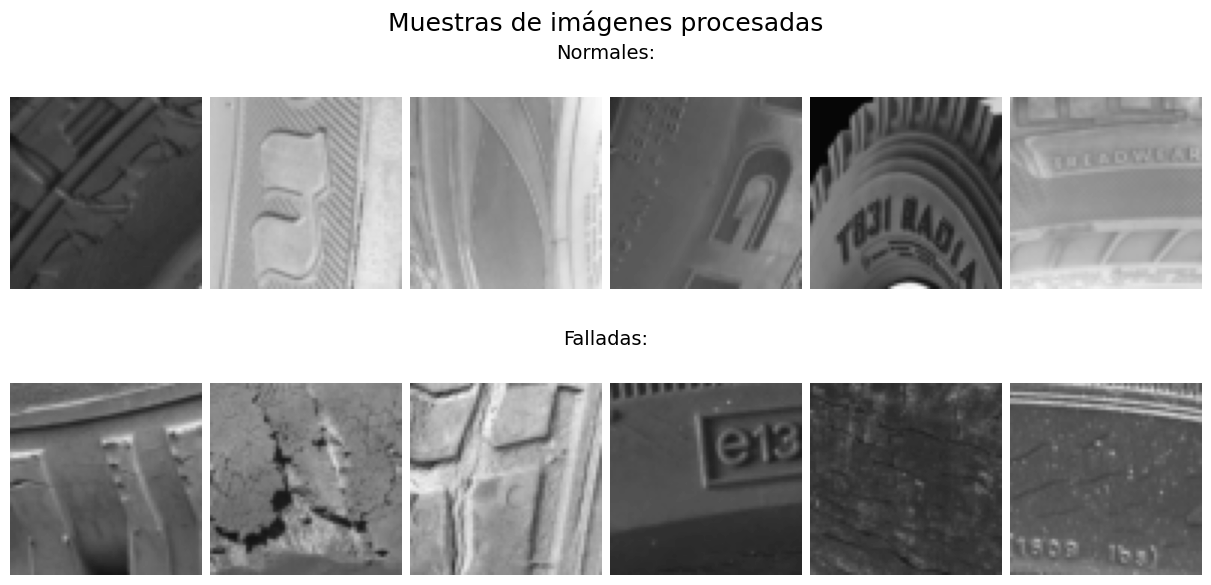

In [223]:
lista_normales = list(entrenamiento_normal_procesados.glob(r"*.png"))
lista_falladas = list(entrenamiento_cracked_procesados.glob(r"*.png"))

fig = plt.figure(constrained_layout=True, figsize=(12, 6))
fig.suptitle('Muestras de imágenes procesadas', size=18)

subfigs = fig.subfigures(nrows=2, ncols=1)

subfigs[0].suptitle('Normales:', size=14)
subfigs[1].suptitle('Falladas:', size=14)

axs = subfigs[0].subplots(nrows=1, ncols=6)
for ax in axs.flat:
    imagen = np.array(Image.open(random.choice(lista_normales)))
    ax.axis('off')
    ax.imshow(imagen, cmap='gray', vmin=0, vmax=255)

axs = subfigs[1].subplots(nrows=1, ncols=6)
for ax in axs.flat:
    imagen = np.array(Image.open(random.choice(lista_falladas)))
    ax.axis('off')
    ax.imshow(imagen, cmap='gray', vmin=0, vmax=255)


## Armado de datasets para entrenamiento y test

In [68]:
def arma_dataset(normales, falladas):
    lista_normales = list(normales.glob(r"*.png"))
    # etiqueta normal = 0
    etiquetas_normales = np.zeros(len(lista_normales))

    lista_falladas = list(falladas.glob(r"*.png"))
    # etiqueta fallada = 1
    etiquetas_falladas = np.ones(len(lista_falladas))

    data_normales = pd.concat(
        [pd.Series(lista_normales, name='nombre'), pd.Series(etiquetas_normales, name='etiqueta')], axis=1)
    data_falladas = pd.concat(
        [pd.Series(lista_falladas, name='nombre'), pd.Series(etiquetas_falladas, name='etiqueta')], axis=1)

    data = pd.concat([data_normales, data_falladas], ignore_index=True)
    # Cambio el orden
    data = data.sample(frac=1, ignore_index=True)
    return data


In [36]:
data_entrenamiento = arma_dataset(entrenamiento_normal_procesados, entrenamiento_cracked_procesados)
data_test = arma_dataset(test_normal_procesados, test_cracked_procesados)

## Descriptor HOG

### Extracción del descriptor HOG

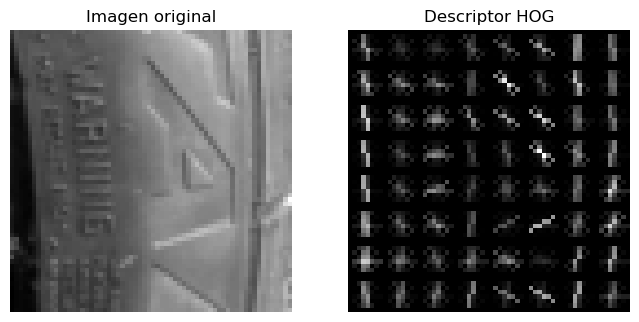

In [217]:
lista_nombres = list(entrenamiento_normal_procesados.glob(r"*.png"))
img = Image.open(lista_nombres[21])

fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), block_norm='L2', transform_sqrt=True, visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.axis('off')
ax1.imshow(img, cmap='gray')
ax1.set_title('Imagen original')

ax2.axis('off')
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('Descriptor HOG')
plt.show()

### Matriz de features HOG y vector target

In [8]:
def vectorHOG(imagen, celda, bloque):
    resultado = hog(imagen, orientations=9, pixels_per_cell=(celda, celda),
                    cells_per_block=(bloque, bloque), block_norm='L2', transform_sqrt=True)
    return resultado


In [13]:
def matrizHOG(dataset, celda=8, bloque=2):
    y = dataset['etiqueta'].to_numpy()
    cantidad = dataset['nombre'].size
    imagen = Image.open(dataset['nombre'][0])
    hogCero = vectorHOG(imagen, celda, bloque)
    X = np.zeros((cantidad, hogCero.size))
    X[0, :] = hogCero
    for i in range(1, cantidad):
        imagen = Image.open(dataset['nombre'][i])
        hog_i = vectorHOG(imagen, celda, bloque)
        X[i, :] = hog_i
    return (X, y)



In [190]:
X_train_hog, y_train_hog = matrizHOG(data_entrenamiento, 8, 2)
X_test_hog, y_test_hog = matrizHOG(data_test, 8, 2)

### Clasificación HOG + SVM


In [211]:
# función para calcular el accuracy de la predicción de neumáticos fallados
def calcula_score(prediccion, datos_reales):
    prediccion_fallados = np.array(prediccion >= 0.5)
    correctos = sum(np.array(prediccion_fallados == datos_reales))

    return correctos / np.size(datos_reales)


#### Prueba de los diferentes kernels de SVM:

In [212]:
# kernel lineal

# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='linear', degree=3, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel lineal): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

 Exactitud HOG + SVM (kernel lineal): 0.6153846153846154


In [219]:
# kernel polinomial grado 1

# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='poly', degree=1, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel polinomial grado 1): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

 Exactitud HOG + SVM (kernel polinomial grado 1): 0.683076923076923


In [220]:
# kernel polinomial grado 2

# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='poly', degree=2, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel polinomial grado 2): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

 Exactitud HOG + SVM (kernel polinomial grado 2): 0.6584615384615384


In [221]:
# kernel polinomial grado 3

# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='poly', degree=3, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel polinomial grado 3): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

 Exactitud HOG + SVM (kernel polinomial grado 3): 0.6584615384615384


In [222]:
# kernel RBF

# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='rbf', degree=2, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel RBF): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

 Exactitud HOG + SVM (kernel RBF): 0.6584615384615384


El kernel que mejor resultado dió es el polinomial de grado 1

## Descriptor LBP

### Extracción del descriptor LBP

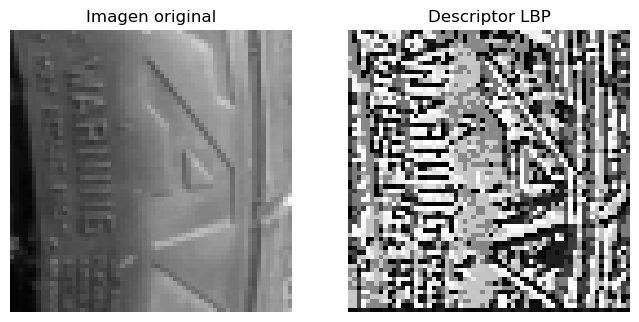

In [158]:
lista_nombres = list(entrenamiento_normal_procesados.glob(r"*.png"))
img = Image.open(lista_nombres[21])

lbp = local_binary_pattern(img, 8, 1, method='default')

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.axis('off')
ax1.imshow(img, cmap='gray')
ax1.set_title('Imagen original')

ax2.axis('off')
ax2.imshow(lbp, cmap='gray')
ax2.set_title('Descriptor LBP')
plt.show()


### Matriz de features LBP y vector target

In [146]:
def vectorLBP(imagen, celda):
    ancho = np.shape(imagen)[1]
    alto = np.shape(imagen)[0]
    lbp = local_binary_pattern(imagen, 8, 1, method='default')
    resultado = np.empty((0, 0))
    for i in range(0, int(alto / celda)):
        for j in range(0, int(ancho / celda)):
            histograma, _ = np.histogram(lbp[i * celda: (i + 1) * celda, j * celda:(j + 1) * celda], bins=256,
                                         range=(0, 256))
            # scaler.fit(hist)
            # scaler.transform(hist)
            normalizado = scale(histograma)
            resultado = np.append(resultado, normalizado)
    return resultado


In [147]:
def matrizLBP(dataset, celda=8, bloque=2):
    y = dataset['etiqueta'].to_numpy()
    cantidad = dataset['nombre'].size
    imagen = Image.open(dataset['nombre'][0])
    lbpCero = vectorLBP(imagen, celda)
    X = np.zeros((cantidad, lbpCero.size))
    X[0, :] = lbpCero
    for i in range(1, cantidad):
        imagen = Image.open(dataset['nombre'][i])
        lbp_i = vectorLBP(imagen, celda)
        X[i, :] = lbp_i
    return (X, y)

In [148]:
# datos de entrenamiento y test
X_train_lbp, y_train_lbp = matrizLBP(data_entrenamiento)
X_test_lbp, y_test_lbp = matrizLBP(data_test)

### Clasificación LBP + SVM

#### Prueba de los diferentes kernels de SVM:

In [223]:
# kernel lineal

# Entrenamiento LBP + SVM
svc_lbp = SVC(kernel='linear', degree=2, probability=True)
svc_lbp.fit(X_train_lbp, y_train_lbp)

# Predicción LBP + SVM
y_pred_lbp = svc_lbp.predict_proba(X_test_lbp)

print(" Exactitud LBP + SVM (kernel lineal): " + str(calcula_score(y_pred_lbp[:, 1], y_test_lbp)))

 Exactitud LBP + SVM (kernel lineal): 0.7569230769230769


In [224]:
# kernel polinomial grado 2

# Entrenamiento LBP + SVM
svc_lbp = SVC(kernel='poly', degree=2, probability=True)
svc_lbp.fit(X_train_lbp, y_train_lbp)

# Predicción LBP + SVM
y_pred_lbp = svc_lbp.predict_proba(X_test_lbp)

print(" Exactitud LBP + SVM (kernel polinomial grado 2): " + str(calcula_score(y_pred_lbp[:, 1], y_test_lbp)))

 Exactitud LBP + SVM (kernel polinomial grado 2): 0.7353846153846154


In [225]:
# kernel polinomial grado 3

# Entrenamiento LBP + SVM
svc_lbp = SVC(kernel='poly', degree=3, probability=True)
svc_lbp.fit(X_train_lbp, y_train_lbp)

# Predicción LBP + SVM
y_pred_lbp = svc_lbp.predict_proba(X_test_lbp)

print(" Exactitud LBP + SVM (kernel polinomial grado 3): " + str(calcula_score(y_pred_lbp[:, 1], y_test_lbp)))

 Exactitud LBP + SVM (kernel polinomial grado 3): 0.7230769230769231


In [226]:
# kernel RBF

# Entrenamiento LBP + SVM
svc_lbp = SVC(kernel='rbf', probability=True)
svc_lbp.fit(X_train_lbp, y_train_lbp)

# Predicción LBP + SVM
y_pred_lbp = svc_lbp.predict_proba(X_test_lbp)

print(" Exactitud LBP + SVM (kernel RBF): " + str(calcula_score(y_pred_lbp[:, 1], y_test_lbp)))

 Exactitud LBP + SVM (kernel RBF): 0.7292307692307692


Para la clasificación con el descriptor LBP el mejor kernel resultó ser el lineal.

## Fusión HOG + LBP + SVM

El paper propone la siguiente fórmula para la fusión de los dos clasificadores:

$$ Score = \lambda_{1} \cdot Score_{HOG} + \lambda_{2} \cdot Score_{LBP} $$

In [249]:
def fusion(prediccion_1, prediccion_2, coeficiente_1, coeficiente_2):
    return prediccion_1 * coeficiente_1 + prediccion_2 * coeficiente_2


Nos quedamos con los kernels que mejor resultado dieron:

In [230]:
# kernel polinomial grado 1 para HOG
# Entrenamiento HOG + SVM

svc_hog = SVC(kernel='poly', degree=1, probability=True)
svc_hog.fit(X_train_hog, y_train_hog)

# Predicción HOG + SVM
y_pred_hog = svc_hog.predict_proba(X_test_hog)

print(" Exactitud HOG + SVM (kernel polinomial grado 1): " + str(calcula_score(y_pred_hog[:, 1], y_test_hog)))

# kernel lineal para LBP:
# Entrenamiento LBP + SVM
svc_lbp = SVC(kernel='linear', degree=2, probability=True)
svc_lbp.fit(X_train_lbp, y_train_lbp)

# Predicción LBP + SVM
y_pred_lbp = svc_lbp.predict_proba(X_test_lbp)

print(" Exactitud LBP + SVM (kernel lineal): " + str(calcula_score(y_pred_lbp[:, 1], y_test_lbp)))


 Exactitud HOG + SVM (kernel polinomial grado 1): 0.683076923076923
 Exactitud LBP + SVM (kernel lineal): 0.7538461538461538


In [356]:
def calcula_fusion(prediccion_1, prediccion_2, dato_real):
    resultado = np.zeros((21, 3))
    resultado[:, 1] = np.linspace(0, 1, 21)
    resultado[:, 2] = 1 - resultado[:, 1]
    for i in range(0, 21):
        score = calcula_score(fusion(prediccion_1, prediccion_2, resultado[i, 1], resultado[i, 2]), dato_real)
        resultado[i, 0] = score
    return resultado

In [357]:
tabla_fusion = calcula_fusion(y_pred_hog[:, 1], y_pred_lbp[:, 1], y_test_hog)
df_fusion = pd.DataFrame(tabla_fusion, columns=['Score', 'Lambda 1', 'Lambda 2'])

In [358]:
display(df_fusion)

,Score,Lambda 1,Lambda 2
0,0.753846,0.00,1.00
1,0.753846,0.05,0.95
2,0.753846,0.10,0.90
3,0.750769,0.15,0.85
4,0.756923,0.20,0.80
5,0.753846,0.25,0.75
6,0.750769,0.30,0.70
7,0.741538,0.35,0.65
8,0.741538,0.40,0.60
9,0.732308,0.45,0.55


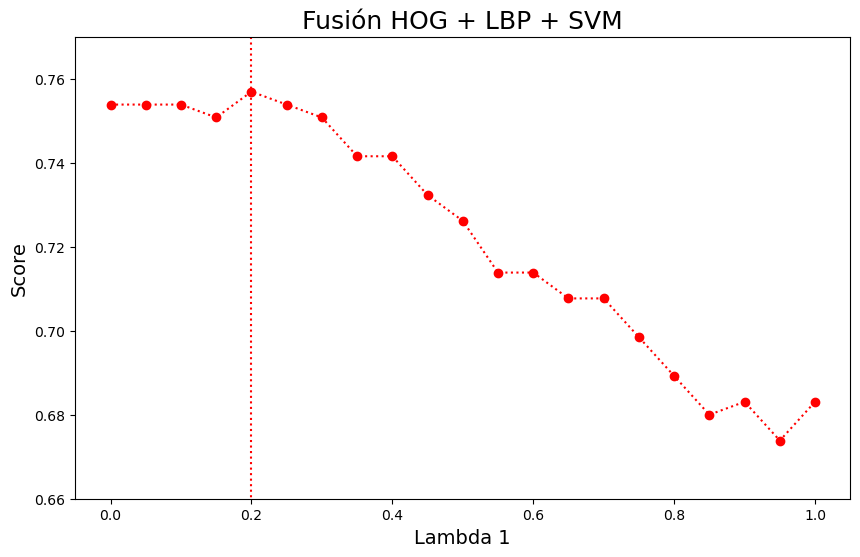

In [324]:
plt.figure(figsize=(10, 6))
plt.plot(df_fusion["Lambda 1"], df_fusion["Score"], 'o:r')
plt.title('Fusión HOG + LBP + SVM', size=18)

plt.ylim((0.66, 0.77))
plt.xlabel("Lambda 1", size=14)
plt.ylabel("Score", size=14)
plt.vlines(0.2, 0.3, 0.77, linestyles='dotted', colors='red')
plt.show()


## Clasificación variando los conjuntos Test y Entrenamiento
La cantidad de datos para test se define en el 20 % del total, unas 206 fotografías para test y 822 para entrenamiento.

In [325]:
dataset_total = pd.concat([data_entrenamiento, data_test], ignore_index=True)

In [326]:
X_HOG, y_HOG = matrizHOG(dataset_total, 8, 2)
X_LBP, y_LBP = matrizLBP(dataset_total)

In [347]:
def calcula_scores(X_dataset, y_dataset, cantidad=10, split=0.2, kernel='poly', grado=1):
    resultado = np.zeros(cantidad)
    for i in range(cantidad):
        X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=split, random_state=i)

        svc = SVC(kernel=kernel, degree=grado, probability=True)
        svc.fit(X_train, y_train)

        y_pred = svc.predict_proba(X_test)
        exactitud = calcula_score(y_pred[:, 1], y_test)
        print(" Exactitud " + str(i) +" : " + str(exactitud))
        resultado[i] = exactitud
    return resultado




In [344]:
resultados_HOG = calcula_scores(X_HOG, y_HOG, 10, 0.2)

 Exactitud 0 : 0.6699029126213593
 Exactitud 1 : 0.6893203883495146
 Exactitud 2 : 0.7087378640776699
 Exactitud 3 : 0.6990291262135923
 Exactitud 4 : 0.6893203883495146
 Exactitud 5 : 0.7378640776699029
 Exactitud 6 : 0.6990291262135923
 Exactitud 7 : 0.6990291262135923
 Exactitud 8 : 0.7135922330097088
 Exactitud 9 : 0.6941747572815534


In [368]:
print("Promedio HOG + SVM : " + str(np.mean(resultados_HOG)))

Promedio HOG + SVM : 0.7


In [348]:
resultados_LBP = calcula_scores(X_LBP, y_LBP, kernel='linear')

 Exactitud 0 : 0.8106796116504854
 Exactitud 1 : 0.8252427184466019
 Exactitud 2 : 0.8495145631067961
 Exactitud 3 : 0.8349514563106796
 Exactitud 4 : 0.8543689320388349
 Exactitud 5 : 0.8349514563106796
 Exactitud 6 : 0.8349514563106796
 Exactitud 7 : 0.8737864077669902
 Exactitud 8 : 0.8446601941747572
 Exactitud 9 : 0.8446601941747572


In [367]:
print("Promedio LBP + SVM : " + str(np.mean(resultados_LBP)))

Promedio LBP + SVM : 0.8407766990291261


### Fusión con tamaño de Test 20 %
Elijo un ajuste aleatorio calculado con un 20 % da datos para test, el rendimiento mejora.

In [351]:
# Entrenamiento HOG + SVM
X_train_hog2, X_test_hog2, y_train_hog2, y_test_hog2 = train_test_split(X_HOG, y_HOG, test_size=0.2, random_state=2)

svc_hog2 = SVC(kernel='poly', degree=1, probability=True)
svc_hog2.fit(X_train_hog2, y_train_hog2)

# Predicción HOG + SVM
y_pred_hog2 = svc_hog2.predict_proba(X_test_hog2)

print(" Exactitud HOG + SVM (kernel polinomial grado 1): " + str(calcula_score(y_pred_hog2[:, 1], y_test_hog2)))


# Entrenamiento LBP + SVM
X_train_lbp2, X_test_lbp2, y_train_lbp2, y_test_lbp2 = train_test_split(X_LBP, y_LBP, test_size=0.2, random_state=2)

svc_lbp2 = SVC(kernel='linear', degree=2, probability=True)
svc_lbp2.fit(X_train_lbp2, y_train_lbp2)

# Predicción LBP + SVM
y_pred_lbp2 = svc_lbp2.predict_proba(X_test_lbp2)

print(" Exactitud LBP + SVM (kernel lineal): " + str(calcula_score(y_pred_lbp2[:, 1], y_test_lbp2)))

 Exactitud HOG + SVM (kernel polinomial grado 1): 0.7087378640776699
 Exactitud LBP + SVM (kernel lineal): 0.8446601941747572


In [359]:
tabla_fusion2 = calcula_fusion(y_pred_hog2[:, 1], y_pred_lbp2[:, 1], y_test_hog2)
df_fusion2 = pd.DataFrame(tabla_fusion2, columns=['Score', 'Lambda 1', 'Lambda 2'])

In [360]:
display(df_fusion2)

,Score,Lambda 1,Lambda 2
0,0.844660,0.00,1.00
1,0.839806,0.05,0.95
2,0.844660,0.10,0.90
3,0.844660,0.15,0.85
4,0.844660,0.20,0.80
5,0.854369,0.25,0.75
6,0.839806,0.30,0.70
7,0.839806,0.35,0.65
8,0.839806,0.40,0.60
9,0.834951,0.45,0.55


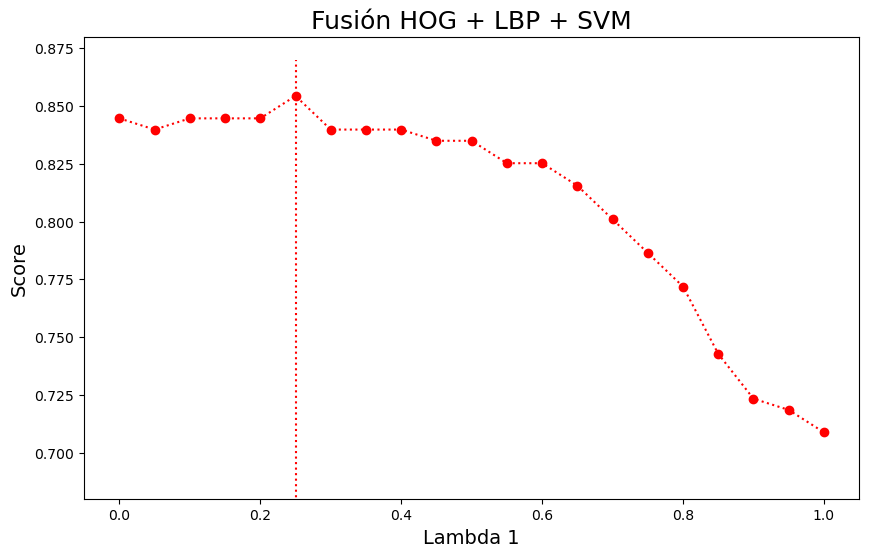

In [365]:
plt.figure(figsize=(10, 6))
plt.plot(df_fusion2["Lambda 1"], df_fusion2["Score"], 'o:r')
plt.title('Fusión HOG + LBP + SVM', size=18)

plt.ylim((0.68, 0.88))
plt.xlabel("Lambda 1", size=14)
plt.ylabel("Score", size=14)
plt.vlines(0.25, 0.3, 0.87, linestyles='dotted', colors='red')
plt.show()

## Conclusiones

El rendimiento mejoró cuando se achicó (se llevó al 20 porciento) el conjunto de datos para test, al principio con 